# Data, Prediction, and Law: 

### An Analysis of the San Francisco Police Incident Report Dataset
---
### Table of Contents

1 - Get the data<br>
2 - Descriptive Statistics<br>
3 - Geographic Data<br>
4 - Mapping Incidents<br>
5 - Discussion Questions<br>





**Dependencies:**

In [1]:
import numpy as np
import pandas as pd
import json
%matplotlib inline
import matplotlib.pyplot as plt
import os
import geopandas as gps
import folium
from folium.plugins import HeatMap


In [2]:
import requests
from shapely.geometry import shape
from branca.colormap import linear
import branca.colormap

### 1 - Loading in Data:

In [3]:
sfpd = pd.read_csv('Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv')
sfpd.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,150060275,NON-CRIMINAL,LOST PROPERTY,Monday,01/19/2015,14:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.421582,37.761701,"(37.7617007179518, -122.42158168137)",15006027571000
1,150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821003074
2,150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821004014
3,150098210,SECONDARY CODES,DOMESTIC VIOLENCE,Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821015200
4,150098226,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Tuesday,01/27/2015,19:00,NORTHERN,NONE,LOMBARD ST / LAGUNA ST,-122.431119,37.800469,"(37.8004687042875, -122.431118543788)",15009822628160


In [4]:
with open('SF Find Neighborhoods.geojson') as f:
    sf_neighborhoods = json.load(f)

### 2 - Descriptive Statistics:

**3.1: Plot the number of incidents per year from 2003-2018. Have crime rates increased or decreased in general?**

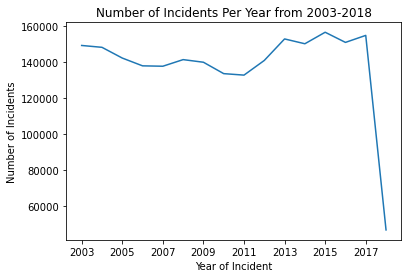

In [5]:
sfpd['Year of Incident'] = sfpd.loc[:,'Date'].str.split('/').str[-1]
incidents_per_year = sfpd.groupby('Year of Incident')['IncidntNum'].count().reset_index()
incidents_per_year.plot(x='Year of Incident').legend().set_visible(False)
plt.ylabel("Number of Incidents")
plt.title('Number of Incidents Per Year from 2003-2018');

**Analysis of Plot**<BR>
The line plot above demonstrates that, between the years 2003 and 2017, the number of reported incidents fluctate: between 2004 and 2006 there was a dip in crime rates, while between 2011 and 2013 there was a substantial increase in crime rates. Because the data only runs until May of 2018 instead of December, it's hard to tell how much crime rates decreased in 2018 since the reported data is not one year's worth. Thus, but evaluating the trends from 2003 to 2017, it seems that on average crime rates have **increased**. This is because the number of incidents reported in 2003-2005 are slightly less than those reported between 2015-2017.

**3.2: Check to see if these relationships change when looking at particular types of crime**

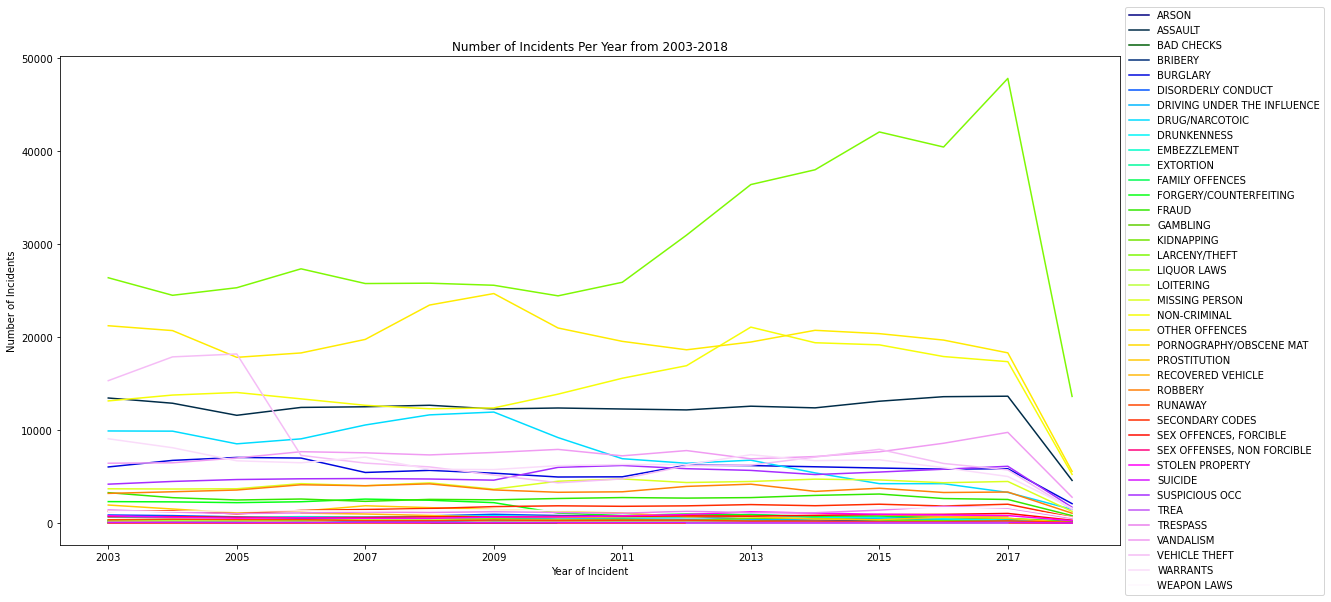

In [6]:
# creating the plot
filtered_crime_per_year = pd.pivot_table(sfpd,'IncidntNum', index=['Category', 'Year of Incident'], aggfunc='count')
ax1 = filtered_crime_per_year.unstack('Category').plot(kind='line', figsize=(19,9))
plt.ylabel("Number of Incidents")
plt.title('Number of Incidents Per Year from 2003-2018')

# adding new colors for the legend
colormap = plt.cm.gist_ncar 
colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])

# changing the legend
ax1.legend(loc=2)
L = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

for i in np.arange(39):
    crimes = ["ARSON", "ASSAULT", "BAD CHECKS", "BRIBERY", "BURGLARY", 
              "DISORDERLY CONDUCT", "DRIVING UNDER THE INFLUENCE", 
             "DRUG/NARCOTOIC", "DRUNKENNESS", "EMBEZZLEMENT", "EXTORTION",
             "FAMILY OFFENCES", "FORGERY/COUNTERFEITING", "FRAUD", "GAMBLING",
             "KIDNAPPING", "LARCENY/THEFT", "LIQUOR LAWS", "LOITERING",
             "MISSING PERSON", "NON-CRIMINAL", "OTHER OFFENCES", 
              "PORNOGRAPHY/OBSCENE MAT", "PROSTITUTION", "RECOVERED VEHICLE",
             "ROBBERY", "RUNAWAY", "SECONDARY CODES", "SEX OFFENCES, FORCIBLE",
             "SEX OFFENSES, NON FORCIBLE", "STOLEN PROPERTY", "SUICIDE",
             "SUSPICIOUS OCC", "TREA", "TRESPASS", "VANDALISM", "VEHICLE THEFT",
             "WARRANTS", "WEAPON LAWS"]
    L.get_texts()[i].set_text(crimes[i])

**Analysis of Plot**<br>
It's interesting to see that Larceny/Theft is the most common among all crimes, and particularly increased from years 2011 to 2015 and it fluctuates similarly like the graph of all incidents from 2003-2018. Non-criminal and Other Offences follow a similar trend, while assault stays flat throughout the years. The rest of the crimes also either fluctuate or stay flat throughout the years.

**3.3: Looking just at 2018, what proportion of the total does each type of crime constitute?**

In [7]:
sfpd_crimes_2018 = sfpd[sfpd['Year of Incident'] == '2018']
filtered_crime_per_year_2 = pd.pivot_table(sfpd_crimes_2018,'IncidntNum', index=['Year of Incident','Category'], aggfunc='count')
total_2018_crimes = filtered_crime_per_year_2.loc[:,'IncidntNum'].sum()
filtered_crime_per_year_2 = filtered_crime_per_year_2.loc[:, 'IncidntNum']/total_2018_crimes
filtered_crime_per_year_2 = pd.DataFrame(filtered_crime_per_year_2)
print('Proportion of Total Crime in 2018:')
filtered_crime_per_year_2

Proportion of Total Crime in 2018:


IncidntNum
Year of Incident Category                               
2018             ARSON                          0.002079
                 ASSAULT                        0.098547
                 BAD CHECKS                     0.000193
                 BRIBERY                        0.000364
                 BURGLARY                       0.044956
                 DISORDERLY CONDUCT             0.002036
                 DRIVING UNDER THE INFLUENCE    0.001971
                 DRUG/NARCOTIC                  0.031756
                 DRUNKENNESS                    0.001800
                 EMBEZZLEMENT                   0.000964
                 EXTORTION                      0.000257
                 FAMILY OFFENSES                0.000279
                 FORGERY/COUNTERFEITING         0.004178
                 FRAUD                          0.017335
                 GAMBLING                       0.000193
                 KIDNAPPING                     0.001564
                 LARCENY/THEFT                  0.292106
                 LIQUOR LAWS                    0.000300
                 LOITERING                      0.000343
                 MISSING PERSON                 0.027085
                 NON-CRIMINAL                   0.112433
                 OTHER OFFENSES                 0.119311
                 PORNOGRAPHY/OBSCENE MAT        0.000064
                 PROSTITUTION                   0.001029
                 ROBBERY                        0.022949
                 RUNAWAY                        0.001864
                 SECONDARY CODES                0.013757
                 SEX OFFENSES, FORCIBLE         0.006836
                 SEX OFFENSES, NON FORCIBLE     0.000236
                 STOLEN PROPERTY                0.005636
                 SUICIDE                        0.000386
                 SUSPICIOUS OCC                 0.036728
                 TRESPASS                       0.011014
                 VANDALISM                      0.059913
                 VEHICLE THEFT                  0.031606
                 WARRANTS                       0.034670
                 WEAPON LAWS                    0.013264

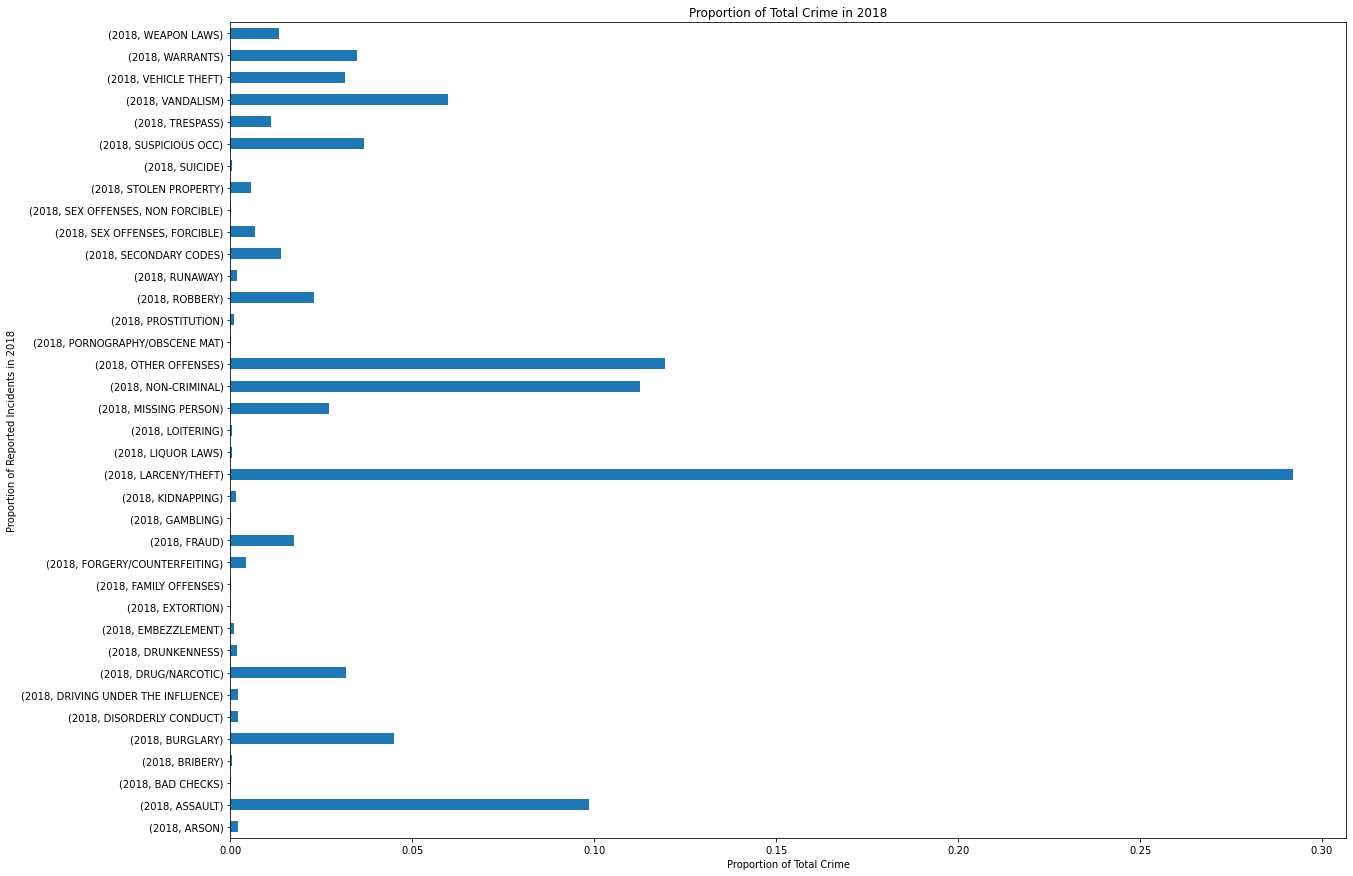

In [8]:
filtered_crime_per_year_2.plot.barh(figsize=(20,15)).legend().set_visible(False)
plt.ylabel('Proportion of Reported Incidents in 2018')
plt.xlabel('Proportion of Total Crime')
plt.title('Proportion of Total Crime in 2018');

**3.4: Is there a relationship between day of week, time, and whether an incident occurs?**

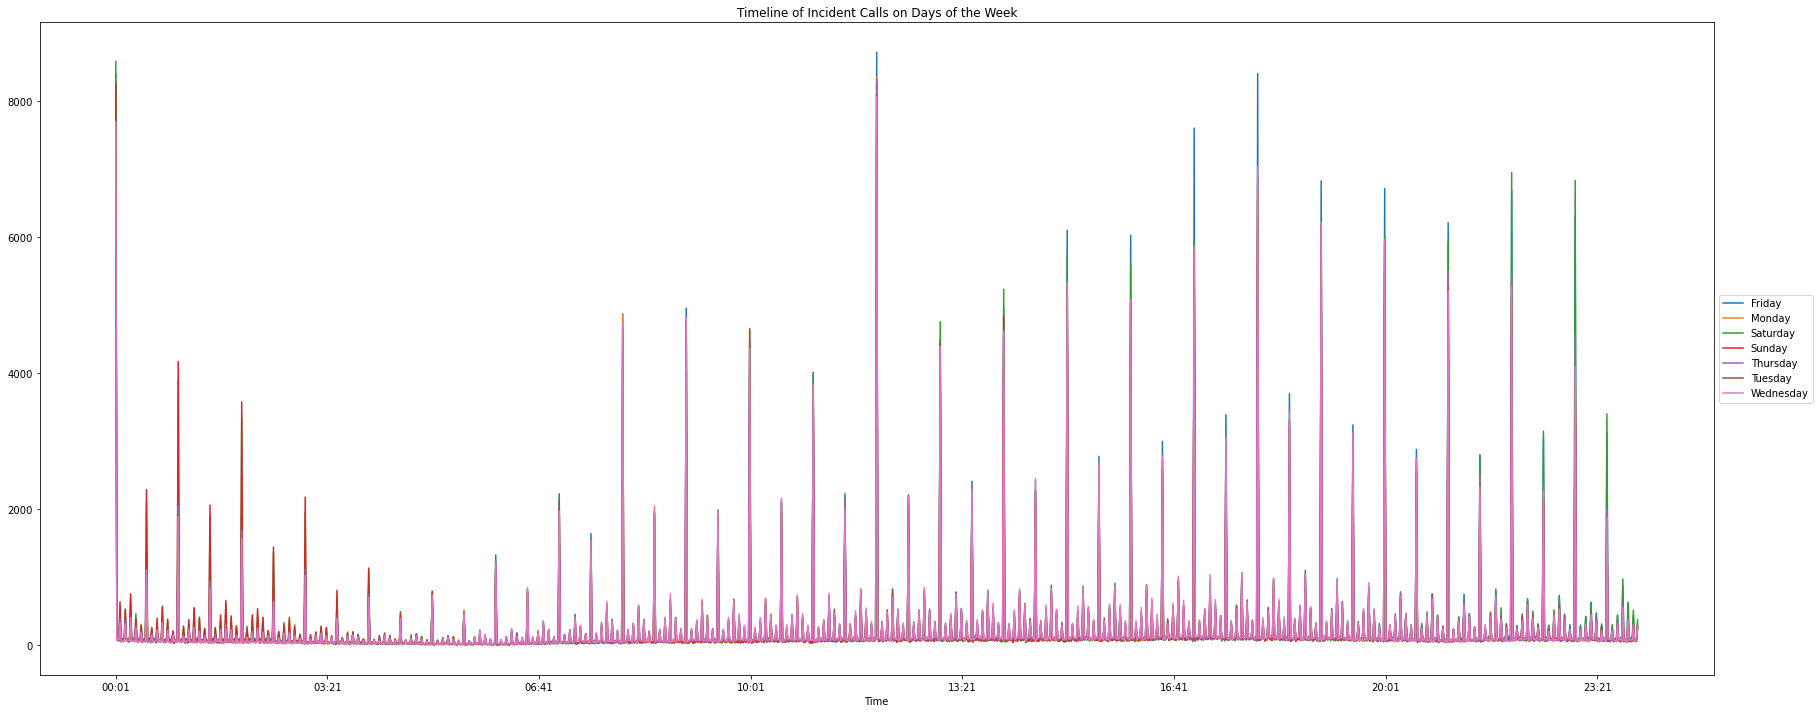

In [9]:
agg_by_day_time = pd.pivot_table(sfpd, 'IncidntNum', index=['Time', 'DayOfWeek'], aggfunc='count')
agg_by_day_time.unstack('DayOfWeek').plot(kind='line', figsize=(30,12))
plt.title('Timeline of Incident Calls on Days of the Week')
L = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for i in np.arange(7):
    crimes = ["Friday", "Monday", "Saturday", "Sunday", "Thursday", "Tuesday", "Wednesday"]
    L.get_texts()[i].set_text(crimes[i]);

**Analysis of Plot**<br>
The line plot above indicates that there are higher police indicent phone calls on Sunday between 12am and 3:30am compared to other days of the week. There are also more police incident phone calls on Friday during hours 3pm and 8pm, compared to other days of the week. Between hours 9pm to 12am there are more phone calls on Saturday. Overall, the lines overlap for weekday phone calls with peaks calls more often reached on Friday, Saturday, and Sunday. As such, there does seem to be a relationship between day of week and time with more calls happening during weekends, specifically moreso during the late-afternoon/evening. An exception to this is at 11:00am, where there is a peak of incident reports.

**3.5: Is there a relationship between day/time and particular types of incidents? What about time of year?**

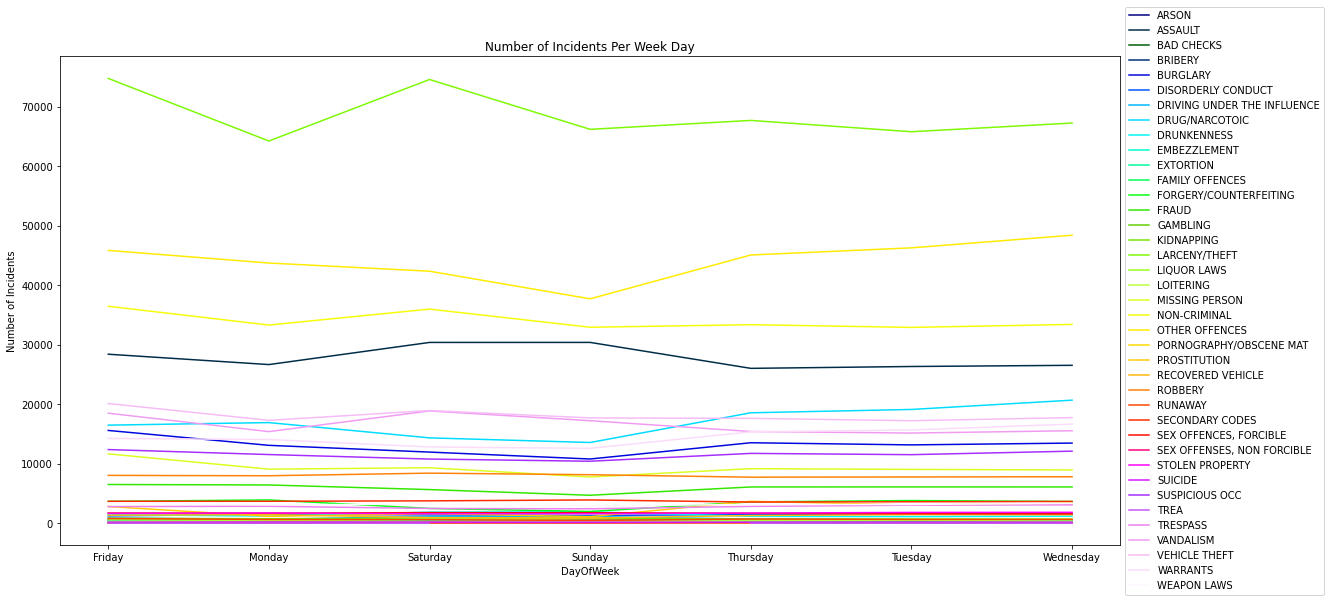

In [10]:
## Weekday vs. Type of Incidents ##

# creating the plot
day_category = pd.pivot_table(sfpd, 'IncidntNum', index=['DayOfWeek', 'Category'], aggfunc='count').sort_values('DayOfWeek')
ax1 = day_category.unstack('Category').plot(kind='line', figsize=(19,9))
plt.ylabel("Number of Incidents")
plt.title('Number of Incidents Per Week Day')

# adding new colors for the legend
colormap = plt.cm.gist_ncar 
colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])

# changing the legend
ax1.legend(loc=2)
L = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

for i in np.arange(39):
    crimes = ["ARSON", "ASSAULT", "BAD CHECKS", "BRIBERY", "BURGLARY", 
              "DISORDERLY CONDUCT", "DRIVING UNDER THE INFLUENCE", 
             "DRUG/NARCOTOIC", "DRUNKENNESS", "EMBEZZLEMENT", "EXTORTION",
             "FAMILY OFFENCES", "FORGERY/COUNTERFEITING", "FRAUD", "GAMBLING",
             "KIDNAPPING", "LARCENY/THEFT", "LIQUOR LAWS", "LOITERING",
             "MISSING PERSON", "NON-CRIMINAL", "OTHER OFFENCES", 
              "PORNOGRAPHY/OBSCENE MAT", "PROSTITUTION", "RECOVERED VEHICLE",
             "ROBBERY", "RUNAWAY", "SECONDARY CODES", "SEX OFFENCES, FORCIBLE",
             "SEX OFFENSES, NON FORCIBLE", "STOLEN PROPERTY", "SUICIDE",
             "SUSPICIOUS OCC", "TREA", "TRESPASS", "VANDALISM", "VEHICLE THEFT",
             "WARRANTS", "WEAPON LAWS"]
    L.get_texts()[i].set_text(crimes[i])

**Analysis of Plot**<br>

The above plot indicates that crime peaks on Friday and Saturday and lowers on Sunday. Crime is the lowest on Monday and stays steady throughout the week.

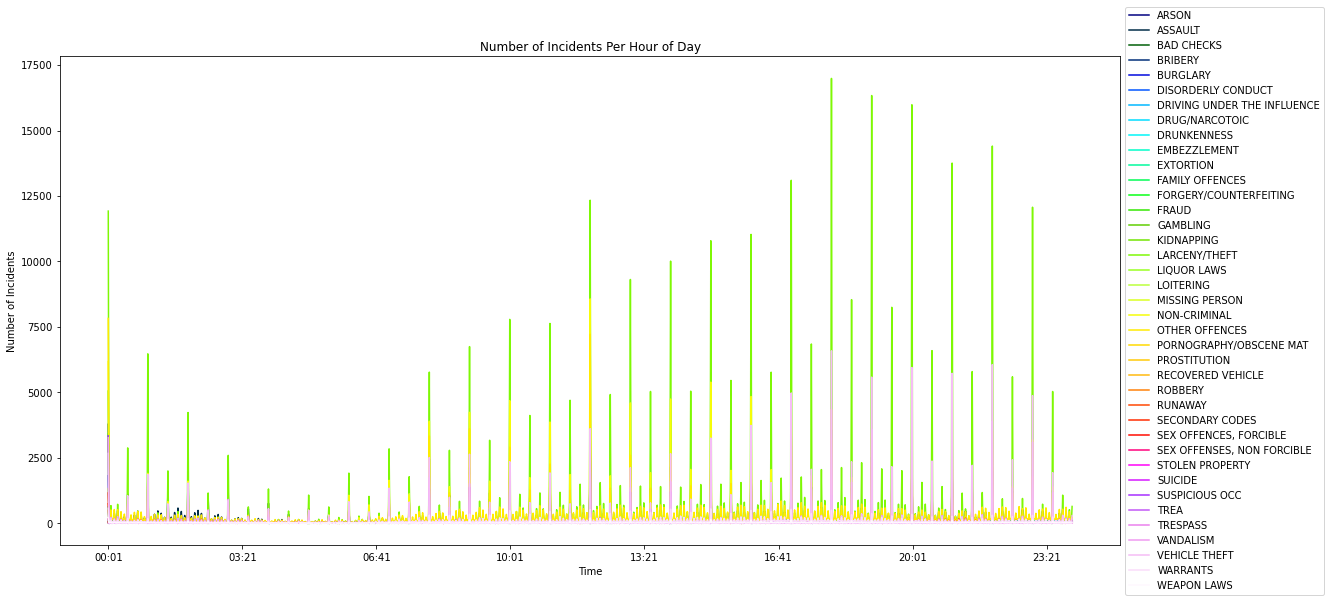

In [11]:
## Time vs. Type of Incidents ##

# creating the plot
time_dategory = pd.pivot_table(sfpd, 'IncidntNum', index=['Time', 'Category'], aggfunc='count')
ax1 = time_dategory.unstack('Category').plot(kind='line', figsize=(19,9))
plt.ylabel("Number of Incidents")
plt.title('Number of Incidents Per Hour of Day')

# adding new colors for the legend
colormap = plt.cm.gist_ncar 
colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])

# changing the legend
ax1.legend(loc=2)
L = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

for i in np.arange(39):
    crimes = ["ARSON", "ASSAULT", "BAD CHECKS", "BRIBERY", "BURGLARY", 
              "DISORDERLY CONDUCT", "DRIVING UNDER THE INFLUENCE", 
             "DRUG/NARCOTOIC", "DRUNKENNESS", "EMBEZZLEMENT", "EXTORTION",
             "FAMILY OFFENCES", "FORGERY/COUNTERFEITING", "FRAUD", "GAMBLING",
             "KIDNAPPING", "LARCENY/THEFT", "LIQUOR LAWS", "LOITERING",
             "MISSING PERSON", "NON-CRIMINAL", "OTHER OFFENCES", 
              "PORNOGRAPHY/OBSCENE MAT", "PROSTITUTION", "RECOVERED VEHICLE",
             "ROBBERY", "RUNAWAY", "SECONDARY CODES", "SEX OFFENCES, FORCIBLE",
             "SEX OFFENSES, NON FORCIBLE", "STOLEN PROPERTY", "SUICIDE",
             "SUSPICIOUS OCC", "TREA", "TRESPASS", "VANDALISM", "VEHICLE THEFT",
             "WARRANTS", "WEAPON LAWS"]
    L.get_texts()[i].set_text(crimes[i])

**Analysis of Plot** <br>
This plot shows that number of reported incident increases during the evening times, particularly those related to larceny/theft. In fact, larceny/theft reports reaches a peak around 5pm. The second highest reports are for non-criminal acts during the daytime,and for vehicle theft during the late evenings.

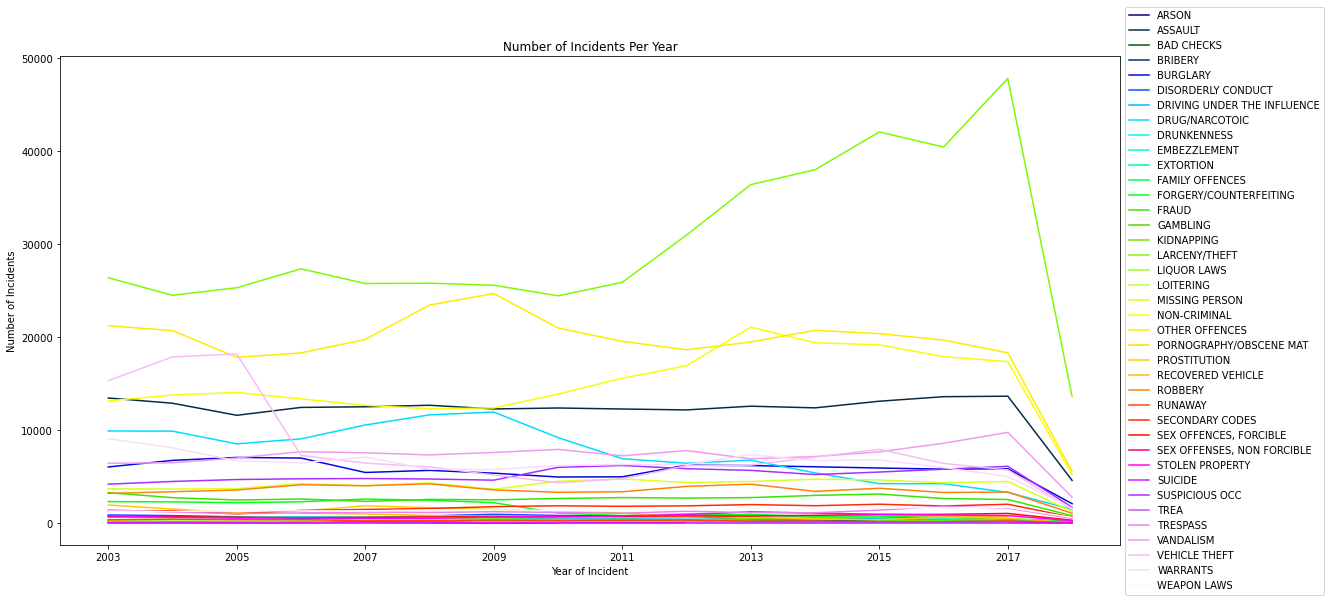

In [12]:
## Year vs. Type of Incidents ##

# creating the plot
year_category = pd.pivot_table(sfpd, 'IncidntNum', index=['Year of Incident', 'Category'], aggfunc='count')
ax1 = year_category.unstack('Category').plot(kind='line', figsize=(19,9))
plt.ylabel("Number of Incidents")
plt.title('Number of Incidents Per Year')

# adding new colors for the legend
colormap = plt.cm.gist_ncar 
colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])

# changing the legend
ax1.legend(loc=2)
L = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

for i in np.arange(39):
    crimes = ["ARSON", "ASSAULT", "BAD CHECKS", "BRIBERY", "BURGLARY", 
              "DISORDERLY CONDUCT", "DRIVING UNDER THE INFLUENCE", 
             "DRUG/NARCOTOIC", "DRUNKENNESS", "EMBEZZLEMENT", "EXTORTION",
             "FAMILY OFFENCES", "FORGERY/COUNTERFEITING", "FRAUD", "GAMBLING",
             "KIDNAPPING", "LARCENY/THEFT", "LIQUOR LAWS", "LOITERING",
             "MISSING PERSON", "NON-CRIMINAL", "OTHER OFFENCES", 
              "PORNOGRAPHY/OBSCENE MAT", "PROSTITUTION", "RECOVERED VEHICLE",
             "ROBBERY", "RUNAWAY", "SECONDARY CODES", "SEX OFFENCES, FORCIBLE",
             "SEX OFFENSES, NON FORCIBLE", "STOLEN PROPERTY", "SUICIDE",
             "SUSPICIOUS OCC", "TREA", "TRESPASS", "VANDALISM", "VEHICLE THEFT",
             "WARRANTS", "WEAPON LAWS"]
    L.get_texts()[i].set_text(crimes[i])

**Analysis of plot** <br>
The number of incidents per year has been in an incline since 2011. There was a period of relative flatness for larceny/theft during 2007 and 2009, and a relatively steady increase after 2011. While theftt/arceny remained flat during 2007 and 2009, other criminal offences increased during that time. Assault has a high number or reported cases throughout the years, but the rate of calls has remained fairly steady.

**3.6: What neighborhoods experience the most crime?  Do different neighborhoods experience different types of crimes at different rates, or is the distribution of crime spatially consistent across neighborhoods?**

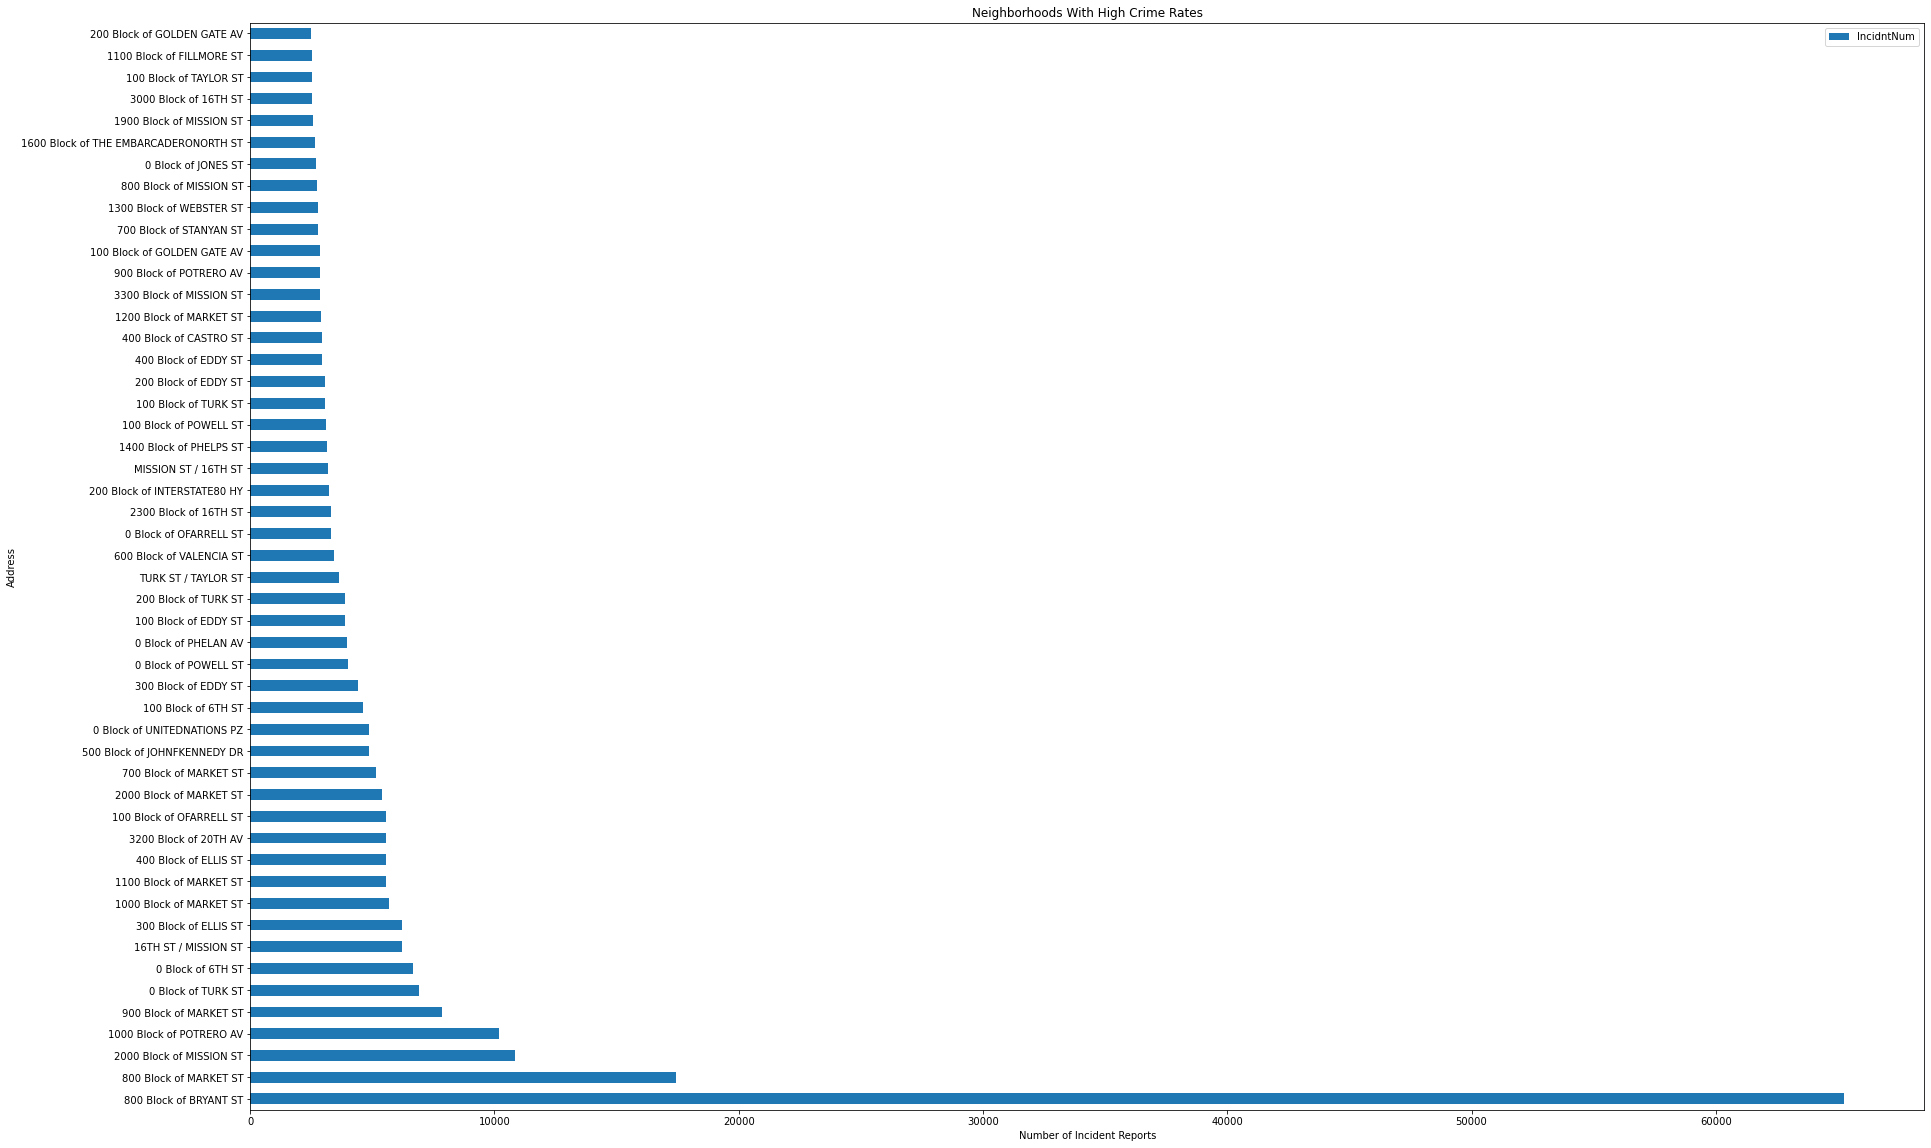

In [13]:
neighborhood_crime = sfpd.loc[:,['Address', 'IncidntNum']].groupby('Address').count().sort_values('IncidntNum', ascending=False).reset_index()
neighborhood_crime_head = sfpd.loc[:,['Address', 'IncidntNum']].groupby('Address').count().sort_values('IncidntNum', ascending=False).reset_index().head(50)
neighborhood_crime_head.plot.barh(x='Address', y='IncidntNum', figsize=(30,20));
plt.xlabel('Number of Incident Reports')
plt.title('Neighborhoods With High Crime Rates');

In [14]:
neighborhood_crime.iloc[1000:1050,:].head(10)

,Address,IncidntNum
1000,2ND ST / TOWNSEND ST,372
1001,5700 Block of MISSION ST,371
1002,300 Block of KING ST,371
1003,0 Block of ELLIS ST,371
1004,1700 Block of LOMBARD ST,370
1005,900 Block of VANNESS AV,370
1006,200 Block of BEACH ST,370
1007,3300 Block of CESAR CHAVEZ ST,369
1008,2500 Block of MARIN ST,369
1009,3RD ST / FOLSOM ST,368


**Analysis of Plot**<br>
800 block of Bryant Street experiences the highest crime- this is evident in the bar chart above, which indicates that there are over 60,000 police incident reports. The neighborhoods surrounding the Financial District/Union Square Area, notably Market Street, also experience high incident reports, though calls fall under 20,000. This makes Bryant street an outlier with how high the number of incident reports are in the area. Different neighborhoods do experience different crime rates, since higher crime rates are especially concentrated near the skyline. The outskirts of SF experience lower crime rates, especially more suburban-like areas. This is evident when looking at various data points after agreggating the police data by Address and ordering them in descending order.

**3.7:  Discuss two other interesting findings from your data.**<br>
It was interesting how despite crime rates fluctuating on a yearly basis, crime rates especially increased between the years 2011 and 2013 (line plot 3.1). Crime rates also increased between 2007 and 2009, which aligns with the years that the United States was in a recession. Though, it's interesting that the increased rates of 2007-2009 were still less than the sudden increase from 2011-2013. It's also interesting how larceny/theft is not only the most common reported crime, but that it is substanially more common than other crimes, especially between the years 2011 and 2017 (line plot 3.2). During those same recession years of 2007 and 2009, larceny/theft actually remained relatively flat, with other crimes increasing dramatically during the period (line plot 3.2).

### 3 - Geographic Data:

**4.1:  Plot individual incidents in 2018 as points on a map of San Francisco**

In [15]:
gpd = gps.GeoDataFrame(sfpd_crimes_2018, crs="EPSG:4326",geometry=gps.points_from_xy(
    x=sfpd_crimes_2018.loc[:,'X'],y=sfpd_crimes_2018.loc[:,'Y'])).sample(1000)

In [16]:
x = gpd['X'].to_list() 
y = gpd['Y'].to_list()
coordinates = []

for i in range(len(x)):
    x_y = (y[i], x[i])
    coordinates.append(x_y)
    
crimes = ["ARSON", "ASSAULT", "BAD CHECKS", "BRIBERY", "BURGLARY", 
              "DISORDERLY CONDUCT", "DRIVING UNDER THE INFLUENCE", 
             "DRUG/NARCOTOIC", "DRUNKENNESS", "EMBEZZLEMENT", "EXTORTION",
             "FAMILY OFFENCES", "FORGERY/COUNTERFEITING", "FRAUD", "GAMBLING",
             "KIDNAPPING", "LARCENY/THEFT", "LIQUOR LAWS", "LOITERING",
             "MISSING PERSON", "NON-CRIMINAL", "OTHER OFFENCES", 
              "PORNOGRAPHY/OBSCENE MAT", "PROSTITUTION", "RECOVERED VEHICLE",
             "ROBBERY", "RUNAWAY", "SECONDARY CODES", "SEX OFFENCES, FORCIBLE",
             "SEX OFFENSES, NON FORCIBLE", "STOLEN PROPERTY", "SUICIDE",
             "SUSPICIOUS OCC", "TREA", "TRESPASS", "VANDALISM", "VEHICLE THEFT",
             "WARRANTS", "WEAPON LAWS"]
    
m = folium.Map([37.7749, -122.4194], zoom_start=12)
for index, i in enumerate(coordinates):
    if gpd.iloc[index]['Category'] == 'DRIVING UNDER THE INFLUENCE':
        folium.Circle(i, color='red', radius=100).add_to(m)
    elif gpd.iloc[index]['Category'] == 'ASSAULT':
        folium.Circle(i, color='orange', radius=100).add_to(m)
    elif gpd.iloc[index]['Category'] == 'NON-CRIMINAL':
        folium.Circle(i, color='yellow', radius=100).add_to(m)
    elif gpd.iloc[index]['Category'] == 'TRESPASS':
        folium.Circle(i, color='green', radius=100).add_to(m)
    elif gpd.iloc[index]['Category'] == 'BURGLARY':
        folium.Circle(i, color='blue', radius=100).add_to(m)
    elif gpd.iloc[index]['Category'] == 'EMBEZZLEMENT':
        folium.Circle(i, color='white', radius=100).add_to(m)
    elif gpd.iloc[index]['Category'] == 'LARCENY/THEFT':
        folium.Circle(i, color='purple', radius=100).add_to(m)
    else:
        folium.Circle(i, color='black', radius=100).add_to(m)
m

**Analysis of Plot** <br>
<br>
**1. Does crime seem randomly distributed in space, or do incidents tend to cluster close together?**<br>
Crime tends to cluster in the Mission District, Financial District, and SOMA areas in this 2018 data. Many of these crimes are larceny/theft (the purple circles), which makes sense since larceny/theft is the most commen type of reported crime. Beyond that, crime is fairly distributed among the outerskirts of SF.
<br>
**2. Shade the points by type of crime and analyze whether certain neighborhoods experience certain types of crime more often**.<br>
The Nob Hill, Mission District, and SOMA have clusters of larceny/theft and non-criminal reports mixed in as well. Burglary appears more spread out throughout SF, though Bayview doesn't experience much burglary.
<br>
**3. Propose social scientific explanations for the patterns that you find.**<br>
There could be more larceny/theft in Nob Hill, SOMA areas because much of SF commerce happens there: large corporations, many businesses and restaurants are all located there and the areas are highly populated with a mix of SF natives and tourists. Thus, criminals likely capitalize on those factors to target either people or public spaces for their crimes.

**4.2:  Merge the incidents data with the GeoJSON describing the boundaries of neighborhoods in San Francisco.**

In [19]:
gpd_all_years = gps.GeoDataFrame(sfpd, crs="EPSG:4326",geometry=gps.points_from_xy(
    x=sfpd.loc[:,'X'],y=sfpd.loc[:,'Y']))
gdf2 = gps.GeoDataFrame.from_features(sf_neighborhoods["features"], crs='epsg:4326')
sfpd_neighborhood = gps.sjoin(gpd_all_years, gdf2, how="left", op='intersects')
sfpd_neighborhood.head(5)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId,Year of Incident,geometry,index_right,link,name
0,150060275,NON-CRIMINAL,LOST PROPERTY,Monday,01/19/2015,14:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.421582,37.761701,"(37.7617007179518, -122.42158168137)",15006027571000,2015,POINT (-122.42158 37.76170),36.0,None,Mission Dolores
1,150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821003074,2015,POINT (-122.41441 37.78419),19.0,http://www.sfgate.com/neighborhoods/sf/tenderl...,Tenderloin
2,150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821004014,2015,POINT (-122.41441 37.78419),19.0,http://www.sfgate.com/neighborhoods/sf/tenderl...,Tenderloin
3,150098210,SECONDARY CODES,DOMESTIC VIOLENCE,Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821015200,2015,POINT (-122.41441 37.78419),19.0,http://www.sfgate.com/neighborhoods/sf/tenderl...,Tenderloin
4,150098226,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Tuesday,01/27/2015,19:00,NORTHERN,NONE,LOMBARD ST / LAGUNA ST,-122.431119,37.800469,"(37.8004687042875, -122.431118543788)",15009822628160,2015,POINT (-122.43112 37.80047),16.0,http://www.sfgate.com/neighborhoods/sf/marina/,Marina


### 4 - Mapping Incidents:

**5.1  Construct a choropleth map, coloring in each neighborhood by how many incidents it had in 2017. Then, construct several maps that explore differences by day of week, time of year, time of day etc.**

In [24]:
geo_data_2017 = sfpd_neighborhood[sfpd_neighborhood['Year of Incident'] == '2017']
sfpd_crimes_2017_by_neighborhood = geo_data_2017.groupby(
    'name').count()['IncidntNum']
sfpd_crimes_2017 = pd.DataFrame(sfpd_crimes_2017_by_neighborhood).reset_index()

incidents_dictionary = sfpd_crimes_2017.set_index('name')['IncidntNum']
color_dictionary = {key: colormap(incidents_dictionary[key]) for key in incidents_dictionary.keys()}

In [25]:
m2 = folium.Map([37.7749, -122.4194], zoom_start=12)

colormap = linear.Set3_07.scale(sfpd_crimes_2017_by_neighborhood.min(), 
                                sfpd_crimes_2017_by_neighborhood.max())

folium.GeoJson(
    sf_neighborhoods,
    name='number of incidents in neighborhoods in 2017',
    style_function=lambda feature: {
        'fillColor': color_dictionary.get(feature['properties']['name'], colormap(0)),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.9,
    }
).add_to(m2)

folium.LayerControl().add_to(m2)

colormap.caption = 'incident number color scale'
colormap.add_to(m2)

m2

**Analysis of Plot**<br>
Central San Francisco and Southwest of San Francisco has lower crime rates in 2017 compared to outher regions. West SF, including Sunset District, has higher incident reports ranging in the 3000-3500 range. Northeast SF has the highest crime rates, particularly in Mission District. This green area exceeds 20,000 incident reports. This area includes Market Street and Powell which are areas of high foot traffic.

**5.2:  Do you notice any patterns?  Are there particular neighborhoods where crime concentrates more heavily?**

There is a pattern that higher crime occurs in areas of more foot traffic. Particular neighborhoods where crime concentrates more heavily includes: South of Market Street and Yerba Buena, which h as the highest crime reports(over 20,000 reports), Hayes Valley which has reports in the 8,000-9,000 range, and Mission Dolores/Moe Valley area which have reports aroung 8,000. Inner mission, which is right next to Moe Valley, also has a high number of reports, around 3,500.

**5.3:  Construct a heat map of crime.**

In [22]:
# How does the heat map compare to the choropleth map? Are neighborhoods a reasonably 
# good proxy for the actual concentration of crime?

sfpd_crimes_2017 = sfpd_neighborhood[sfpd_neighborhood['Year of Incident'] == '2017']

x2 = sfpd_crimes_2017['X'].to_list() 
y2 = sfpd_crimes_2017['Y'].to_list()
coordinates2 = []

for i in range(len(x)):
    x_y = (y[i], x[i])
    coordinates2.append(x_y)

m3 = folium.Map([37.7749, -122.4194], zoom_start=12)

HeatMap(coordinates2, radius=14).add_to(m3)
m3

**Analysis of Plot** <br>
This heat map highlights the same ideas analyzed from the choropleth map above, but moreso in a broader sense. The choropleth map is more specific since it shows the specific amount of incident reports per neighborhood, but the heat map is more general and emphasizes the broader reigion which crime occurs. Since this heat plot enables us to see more of the map since all areas are not colored,  we can see that central SF has very little incident reports compared to the rest of SF, and zooming in it's clear that this is because Mount Sutro, Glen Canyon Park, and other recreational areas make up that region. These areas may have. lower foot traffic, especially compared to Market Steet where incident reports are high. The Presidio also has little to no incident reports, and this could also be because it's a more green area that is made up of fields and golf courses. Neighborhoods are a resonably good proxy for the actual concentration of crime because there are certain characteristics that are associated with neighborhoods that affect crime rates. For example, neighborhoods that are more populated or close to restaurants, stores, and companies have higher crime rates as depicted in the heat map above.

### 5 - Discussion Questions:

**6.1:  Based on the evidence from this lab assignment, why do you think “hotspots” policing became more popular in the last few decades? What are the pros and cons to this kind of approach?**

I think "hotspots" policing became more popular in the last few decades because it allows the policeforce to allocate its limited resources in certain areas to mitigate crime, rather than trying to deploy police/allocate resources in a larger number of areas. This is also helpful because police can easily ask for backup when everyone is close by. The pros to this approach is that if this method works, then crime could be reduced in the most efficient way and there would be a precedent set that people will be caught for criminal acts so they should not even attempt them. The cons are that if these hotspots are marginalized communities, they would be disproportionately surveilled while other more affluent communities that may commit similar crimes will go unseen.
<br>
As discussed in Big Data Surveillance: The Case of Policing, and the class discussion with Sarah Brayne, police departments are increasingly leaning on predictive policing to determine which areas to monitor. More often than not, they are not aware of the biases incorporated in these algorithms, so when cops police the areas that are suggested by an algorithm and they arrest criminals in those regions, it continues to feed these algorithms data that make them increasingly more biased. In other words, police monitor criminal activity hotspots and when they catch criminals in these hotspots, it further affirms to them that this method is effective.

**6.2:  Comment on what sorts of incidents get reported in this database**

According to the above analysis, there are 39 categories of crimes, and each category has a vast list of descriptions of crimes that fall into that category. Theft is among the top reported crimes, followed by non-criminal (lost property), assault, vehicle theft, warrants, suspicious occurence, among other crimes. There are white-collar crimes such as embezzlement, with a total of 2988 reported crimes, though this is a small number of reported crimes compared to other categories. I think these incident cateogies were selected based on common occurrence and based on how broad they are to account for the various descriptions of crimes. As data scientists, we should be aware of legal concerns such as, "how does each description fall under its respective category if certain categories have higher sentences than others?" Ethical questions follow a similar style in that, if a crime can fall under two different categories, then which one should bc chosen if boththose categories have different sentences?


**6.3:  What other sorts of data would help improve your analysis?**

Other sorts of data regarding the people involved in the criminal act would be helpful for my analysis. This info could include the amount of people involved in the incident report, and whether or not they were convicted. This type of data would also help with this idea of policing "hotspots", because if there are incident reports but the people that were reported were actually innocent then police should allocate their resources in different areas. As such, with this information there could be a greater focus on the outcome of the incident reports rather than information on the initial report.